[← Previous: Dataset Comparison - Human vs AI Labels](05_dataset_comparison_analysis.ipynb)

# **Building a Random Forest for Anxiety Trigger Classification**

**The Goal:** To see if a random forest classifier can predict which Reddit posts trigger high anxiety.

**The Approach:** Compare three labeling strategies (hand-annotated, AI-generated, and combined) to find the optimal balance between annotation quality and dataset size.

---


## Table of Contents

1. [Setup](#1-setup)
2. [Load Pre-trained Models](#2-load-pre-trained-models)
3. [Create Three Label Sets](#3-create-three-label-sets)
4. [Build Features](#4-build-features)
5. [Train and Compare](#5-train-and-compare)
6. [Save Model for Production](#6-save-model-for-production)
7. [Generate Report Statistics](#7-generate-report-statistics)
8. [Limitations and Future Work](#8-limitations-and-future-work)
9. [Ablation Study](#9-ablation-study)
10. [Advanced Failure Analysis](#10-advanced-failure-analysis)

[Next: Text Classification with Logistic Regression →](08_text_classification_logistic_regression_classifier.ipynb)



---


In [116]:
# Install dependencies (remove -q to see output)
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


---

## **1. Setup**

Import libraries, set paths, define random seed for reproducibility.

In [117]:
# Standard Library
import os
import json
import warnings
from pathlib import Path

# Data Processing
import numpy as np
import pandas as pd
import joblib

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

# Sparse Matrix Operations
from scipy.sparse import hstack, csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# CONFIGURATION
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Project Paths
DATA = Path("../data")                # Raw data directory
PROC = DATA / "processed"             # Processed data
ART = Path("../artifacts")            # Saved models, vectorizers, outputs

# Tokenization Rules
TEXT_COL = "text_all"                 # Column containing full post text
PUNCT = ".,!?:;()[]{}\"'""''-–—/\\"   # Characters to strip from word boundaries
TRASH = {                             # Domain-specific noise to remove
    "[text]", 
    "[image]", 
    "[removed]", 
    "[deleted]"
}
KEEP_SHORT = {                         # Mental health terms to preserve
    "ecg", 
    "sad", 
    "ptsd", 
    "mom", 
    "dad", 
    "anx"
}


# TOKENIZATION FUNCTION
def tokenize(s):
    """
    Tokenize text with domain-specific rules for mental health posts.
    
    Rules:
    - Strip punctuation and lowercase
    - Remove Reddit artifacts ([removed], [deleted], etc.)
    - Keep words ≥3 characters OR domain-specific short terms
    
    Args:
        s (str): Input text
        
    Returns:
        list: Cleaned tokens
    """
    tokens = []
    for word in str(s).split():
        word = word.strip().strip(PUNCT).lower()
        if word and word not in TRASH and (len(word) >= 3 or word in KEEP_SHORT):
            tokens.append(word)
    return tokens


# CONFIRMATION
print("Setup complete")
print(f"  - Data path: {PROC}")
print(f"  - Artifacts path: {ART}")
print(f"  - Random seed: {SEED}")
print(f"  - Tokenization: {len(KEEP_SHORT)} special terms preserved")

Setup complete
  - Data path: ../data/processed
  - Artifacts path: ../artifacts
  - Random seed: 42
  - Tokenization: 6 special terms preserved


---

## **2. Load Pre-trained Models**

In this section we combine the pre-trained feature extractors (from unsupervised learning) with newly created labels to train our anxiety classifier.

**What we're loading and why:**

| Component | Source | Purpose |
|-----------|--------|---------|
| **Main Dataset** | `reddit_anxiety_v1_with_nrc.parquet` (preferred)<br/>`reddit_anxiety_v1.parquet` (fallback) | 6,283 Reddit posts with preprocessed text + optional NRC anxiety scores |
| **Hand Labels** | `sample_human_labels.csv` | 599 posts rated by human annotator (0-5 scale) |
| **AI Labels** | `simple_ai_labels.csv` | 1,000 posts labeled using GPT-3.5-turbo API (0-5 scale) |
| **TF-IDF Vectorizer** | `vec_final.joblib` | Pre-trained on all 6,283 posts -> converts text to ~9,699 features |
| **NMF Topic Model** | `nmf_final.joblib` | Pre-trained on all 6,283 posts -> extracts 15 topic distributions |
| **NRC Emotion Lexicon** | `NRC-Emotion-Lexicon-Wordlevel-v0.92.txt` | Used to calculate anxiety scores as metadata features (if available) |

**Why are we using pre-trained?** The TF-IDF and NMF models learned general patterns from *all* posts (unlabeled), which gives us better vocabulary coverage and topic definitions than training only on the 1,006 labeled posts. 

**Why NRC Emotion Lexicon?** The NRC Emotion Lexicon (Mohammad & Turney, 2013) provides psychologically-grounded anxiety signals that complement our lexical and semantic features. The lexicon contains word-emotion associations for eight basic emotions including fear and anxiety, derived from crowdsourced annotations. Unlike TF-IDF (which captures word frequency) or NMF topics (which capture semantic themes), NRC captures **emotional valence** - the psychological impact of words on anxiety levels.

**NRC Anxiety Score Formula:**

```
anxiety_score = (1.0×fear + 0.7×sadness + 0.6×anger + 0.6×disgust + 0.4×anticipation + 0.3×surprise - 0.5×joy - 0.4×trust + 0.3×negative - 0.2×positive) / n_tokens^0.3

normalized_score = sigmoid(anxiety_score)
```

This weighted combination of emotions provides a **domain-specific anxiety signal** that helps the model distinguish between casual mentions of anxiety-related words and genuine emotional distress.

**Note:** If `reddit_anxiety_v1_with_nrc.parquet` doesn't exist, run `python src/add_nrc_features.py` to generate it.

In [118]:
# ============================================================================
# LOAD DATA AND ARTIFACTS
# ============================================================================

def identity(x): 
    """Identity function needed for unpickling TF-IDF vectorizer with custom tokenizer."""
    return x

# Try to load NRC-enhanced dataset first, fallback to regular dataset
nrc_file = PROC / "reddit_anxiety_v1_with_nrc.parquet"
regular_file = PROC / "reddit_anxiety_v1.parquet"

if nrc_file.exists():
    df = pd.read_parquet(nrc_file)
    has_nrc_features = True
    print(f" Loaded NRC-enhanced dataset: {df.shape}")
else:
    df = pd.read_parquet(regular_file)
    has_nrc_features = False
    print(f"! Loaded regular dataset (no NRC features): {df.shape}")
    print(f"   To enable NRC features, run: python src/add_nrc_features.py")

vec = joblib.load(ART / "vec_final.joblib")
nmf = joblib.load(ART / "nmf_final.joblib")
df_hand = pd.read_csv(PROC / "sample_human_labels.csv")
df_ai = pd.read_csv(PROC / "simple_ai_labels.csv")

print(f"Dataset loaded: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Validate dataset integrity
if TEXT_COL not in df.columns:
    raise ValueError(f"Required text column '{TEXT_COL}' not found in dataset. Available columns: {list(df.columns)}")

if 'post_id' not in df.columns:
    raise ValueError(f"Required 'post_id' column not found in dataset. Available columns: {list(df.columns)}")

# Check for NRC scores if available
if has_nrc_features:
    if 'anxiety_score' not in df.columns:
        print("[WARNING] NRC file loaded but anxiety_score column missing")
        has_nrc_features = False
    else:
        nrc_min, nrc_max = df['anxiety_score'].min(), df['anxiety_score'].max()
        print(f"NRC anxiety_score range: {nrc_min:.3f} to {nrc_max:.3f}")
        if nrc_min < 0 or nrc_max > 1:
            print(f"[WARNING] NRC scores outside expected range [0,1]. This may indicate normalization issues.")
else:
    print("NRC features not available - using 2 metadata features instead of 3")

print(f"\n{'='*60}\nLOADED DATA\n{'='*60}")
print(f"Posts: {len(df):,} | TF-IDF: {vec.max_features:,} features | "
      f"Topics: {nmf.n_components}")
print(f"Labels: {len(df_hand):,} hand | {len(df_ai):,} AI")
print(f"{'='*60}")

# df.head()

! Loaded regular dataset (no NRC features): (6283, 18)
   To enable NRC features, run: python src/add_nrc_features.py
Dataset loaded: (6283, 18)
Columns: ['post_id', 'subreddit', 'created_ts', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category', 'created_dt', 'title_clean', 'selftext_clean', 'comments_concat', 'comment_count', 'text_main', 'text_all', 'comments_missing']
NRC features not available - using 2 metadata features instead of 3

LOADED DATA
Posts: 6,283 | TF-IDF: 10,000 features | Topics: 15
Labels: 599 hand | 1,000 AI


In [119]:
# ============================================================================
# VERIFICATION: check feature dimensions
# ============================================================================

print(f"\n{'='*60}\nFEATURE VERIFICATION\n{'='*60}")

print(f"TF-IDF: {vec.max_features:,} max features")
print(f"NMF Topics: {nmf.n_components} topics")

sample_text = df[TEXT_COL].iloc[0]
sample_tokens = tokenize(sample_text)

print(f"\nSample post: {len(sample_text)} chars -> {len(sample_tokens)} tokens")
print(f"First 5 tokens: {sample_tokens[:5]}")

X_tfidf_sample = vec.transform([sample_tokens])
W_topics_sample = nmf.transform(X_tfidf_sample)

doc_len_val = len(sample_tokens)
has_url_val = int("http" in sample_text.lower())
nrc_val = df["anxiety_score"].iloc[0] if "anxiety_score" in df.columns else 0.0

print(f"\nMetadata: doc_len={doc_len_val}, has_url={has_url_val}, nrc_score={nrc_val:.3f}")

# Calculate total features based on whether NRC is available
metadata_count = 3 if has_nrc_features else 2
total_features = X_tfidf_sample.shape[1] + W_topics_sample.shape[1] + metadata_count

if has_nrc_features:
    print(f"\nTotal features: {X_tfidf_sample.shape[1]:,} (TF-IDF) + "
          f"{W_topics_sample.shape[1]} (topics) + 3 (metadata: doc_len, has_url, nrc_score) = {total_features:,}")
else:
    print(f"\nTotal features: {X_tfidf_sample.shape[1]:,} (TF-IDF) + "
          f"{W_topics_sample.shape[1]} (topics) + 2 (metadata: doc_len, has_url) = {total_features:,}")
    print("💡 NRC features not available - using 2 metadata features instead of 3")

print(f"{'='*60}")


FEATURE VERIFICATION
TF-IDF: 10,000 max features
NMF Topics: 15 topics

Sample post: 1170 chars -> 164 tokens
First 5 tokens: ['how', 'you', 'calm', 'your', 'mind']

Metadata: doc_len=164, has_url=0, nrc_score=0.000

Total features: 9,699 (TF-IDF) + 15 (topics) + 2 (metadata: doc_len, has_url) = 9,716
💡 NRC features not available - using 2 metadata features instead of 3


---

## **3. Create Three Label Sets**

Compare three labeling strategies: hand-annotated, AI-generated, and combined.

**Labeling Criteria:**
- **Hand-annotated:** Single annotator rated posts on 0-5 scale. High anxiety threshold = rating ≥4.
- **AI-generated:** Posts labeled using GPT-3.5-turbo API with GAD-7 adapted scale (0-5 severity levels).
- **Combined:** Union of both sources. For overlapping posts, prioritize hand labels over AI labels.

**Note:** Actual dataset sizes and class distributions are reported in the code output below.

*Limitation: Hand labels represent single-annotator judgment without inter-annotator reliability validation (see Section 8).*

In [120]:
# ============================================================================
# CREATE LABEL SETS FOR MODEL TRAINING
# ============================================================================

label_sets = {}

# 1. HAND-ANNOTATED LABELS
print(f"\n{'='*60}\nProcessing labels\n{'='*60}")

df_h = df_hand[["post_id"]].copy()

if "anxiety_rating" in df_hand.columns:
    rating = pd.to_numeric(df_hand["anxiety_rating"], errors="coerce")
    df_h["label"] = (rating >= 4).astype(int)
else:
    raise ValueError("anxiety_rating column not found in hand-annotated data")

print(f"Hand: {len(df_h)} posts | {df_h['label'].sum()} positive ({100*df_h['label'].mean():.1f}%)")

label_sets["hand"] = df_h

# 2. AI-GENERATED LABELS
cat = df_ai["ai_category"].astype(str).str.lower()
conf = pd.to_numeric(df_ai["ai_confidence"], errors="coerce").fillna(0)
sev = pd.to_numeric(df_ai["ai_severity"], errors="coerce").fillna(0)

df_a = df_ai[["post_id"]].copy()
df_a["label"] = (
    (cat.str.contains("anx") | cat.str.contains("panic")) &
    (sev >= 4) &
    (conf >= 0.5)
).astype(int)

print(f"AI:   {len(df_a)} posts | {df_a['label'].sum()} positive ({100*df_a['label'].mean():.1f}%)")

label_sets["ai"] = df_a

# 3. COMBINED LABELS
df_h_temp = df_h.copy()
df_h_temp["source"] = "hand"

df_a_temp = df_a.copy()
df_a_temp["source"] = "ai"

df_comb = pd.concat([df_h_temp, df_a_temp], ignore_index=True)
df_comb = df_comb.sort_values("source").drop_duplicates("post_id", keep="last")

overlap = len(df_h) + len(df_a) - len(df_comb)

print(f"Comb: {len(df_comb)} posts | {df_comb['label'].sum()} positive ({100*df_comb['label'].mean():.1f}%) | "
      f"Overlap: {overlap}")

label_sets["combined"] = df_comb[["post_id", "label"]]

print(f"\nNote: Hand labels prioritized for {overlap} overlapping posts")
print(f"{'='*60}")


Processing labels
Hand: 599 posts | 114 positive (19.0%)
AI:   1000 posts | 147 positive (14.7%)
Comb: 1006 posts | 173 positive (17.2%) | Overlap: 593

Note: Hand labels prioritized for 593 overlapping posts


---

## **4. Build Features**

Convert text into numerical features that Random Forest can learn from. We combine three complementary feature types to capture both lexical patterns and semantic meaning.

**Feature composition (9,716-9,717 per post):**
- **9,699 TF-IDF scores:** Which words appear and how important they are (pre-trained vocabulary)
- **15 topic probabilities:** What themes/topics the post discusses (pre-trained NMF model)
- **2-3 metadata features:** Post characteristics (document length, URL presence, + optional NRC anxiety score)

**Why did we choose this combination?** TF-IDF captures specific anxiety-related words ("panic", "attack"), topics capture broader themes (health anxiety vs. social anxiety), and metadata provides context. Together they give a richer representation than text alone.


```mermaid
flowchart LR
    A[Raw Text Post] --> B[Tokenize Text]
    B --> C{Split into<br/>3 Paths}
    
    C --> D[TF-IDF<br/>Vectorizer]
    C --> E[NMF<br/>Topic Model]
    C --> F[Metadata<br/>Extraction]
    
    D --> G[9,699<br/>word scores]
    E --> H[15 topic<br/>probabilities]
    F --> I{2-3 features:<br/>length, URL<br/>+ NRC?}
    
    I --> I1[2 features:<br/>length, URL]
    I --> I2[3 features:<br/>length, URL, NRC]
    
    G --> J[Horizontal<br/>Stack]
    H --> J
    I1 --> J
    I2 --> J
    
    J --> K[Final Feature Matrix<br/>9,716-9,717 features<br/>Ready for Random Forest]
    
    style A fill:#818CF8,stroke:#6366F1,stroke-width:3px,color:#fff
    style B fill:#60A5FA,stroke:#3B82F6,stroke-width:2px,color:#fff
    style C fill:#FB7185,stroke:#E11D48,stroke-width:2px,color:#fff
    style D fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style E fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style F fill:#A78BFA,stroke:#8B5CF6,stroke-width:2px,color:#fff
    style G fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style H fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style I fill:#F59E0B,stroke:#D97706,stroke-width:2px,color:#fff
    style I1 fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style I2 fill:#2DD4BF,stroke:#14B8A6,stroke-width:2px,color:#000
    style J fill:#60A5FA,stroke:#3B82F6,stroke-width:2px,color:#fff
    style K fill:#10B981,stroke:#059669,stroke-width:3px,color:#fff
```

In [121]:
# ============================================================================
# BUILD FEATURES FOR EACH LABEL SET
# ============================================================================

datasets = {}  # Store X, y for each label source

print(f"\n{'='*60}\nBUILDING FEATURES\n{'='*60}")

for name, df_labels in label_sets.items():
    
    # 1. PREPARE DATA: Match labeled posts to main dataset
    df_subset = df[df['post_id'].isin(df_labels['post_id'])].copy()
    df_subset = df_subset.merge(df_labels, on='post_id', how='inner')
    
    # Tokenize text for vectorization
    tokens = df_subset[TEXT_COL].fillna("").map(tokenize)
    
    # 2. EXTRACT FEATURES
    # Feature Type 1: TF-IDF (text importance)
    X_tfidf = vec.transform(tokens)
    
    # Feature Type 2: NMF Topics (semantic themes)
    W_topics = nmf.transform(X_tfidf)
    
    # Feature Type 3: Metadata Features
    doc_len = np.array([len(t) for t in tokens])[:, None]                    # Document length
    has_url = df_subset[TEXT_COL].fillna("")\
                       .str.contains("http", case=False)\
                       .astype(int).values[:, None]                          # URL indicator
    
    # Handle NRC features conditionally
    if has_nrc_features:
        nrc = df_subset.get("anxiety_score", pd.Series(0, index=df_subset.index))\
                       .fillna(0).values[:, None]                            # NRC anxiety score
        X_dense = np.hstack([W_topics, doc_len, has_url, nrc])
        metadata_count = 3
    else:
        X_dense = np.hstack([W_topics, doc_len, has_url])
        metadata_count = 2
    
    # 3. COMBINE FEATURES
    # Stack dense features: Topics (15) + metadata (2 or 3)
    X_dense = np.nan_to_num(X_dense, nan=0.0)
    
    # Combine sparse TF-IDF + dense features
    X = hstack([X_tfidf, csr_matrix(X_dense)], format="csr")
    X.data = np.nan_to_num(X.data, nan=0.0)
    
    # 4. EXTRACT LABELS & STORE
    y = df_subset["label"].values
    datasets[name] = {"X": X, "y": y}
    
    print(f"{name:10s} | X: {X.shape} | y: {len(y):4d} | "
          f"pos: {y.sum():3d} ({100*y.mean():4.1f}%)")

print(f"\nFeatures: {X_tfidf.shape[1]:,} TF-IDF + {W_topics.shape[1]} topics + "
      f"{metadata_count} metadata = {X.shape[1]:,} total")
if has_nrc_features:
    print("Metadata features: doc_len, has_url, nrc_score")
else:
    print("Metadata features: doc_len, has_url (NRC not available)")
print(f"{'='*60}")


BUILDING FEATURES
hand       | X: (599, 9716) | y:  599 | pos: 114 (19.0%)
ai         | X: (1000, 9716) | y: 1000 | pos: 147 (14.7%)
combined   | X: (1006, 9716) | y: 1006 | pos: 173 (17.2%)

Features: 9,699 TF-IDF + 15 topics + 2 metadata = 9,716 total
Metadata features: doc_len, has_url (NRC not available)


---

## **5. Train and Compare**

**Method:** 80/20 train-test split, Random Forest (600 trees), optimize F1 threshold for each model

**Approach:** Train separate models on each label source and compare performance metrics (AUC, Average Precision, optimal threshold).

**Why Random Forest?** This method handles high-dimensional sparse features well without requiring feature scaling or extensive hyperparameter tuning.

In [122]:
# ============================================================================
# TRAIN RANDOM FOREST ON EACH LABEL SOURCE
# ============================================================================

results = []

for name in ["hand", "ai", "combined"]:
    
    print(f"\n{'='*60}\nTRAINING: {name.upper()}\n{'='*60}")
    
    # Validate dataset exists
    if name not in datasets:
        raise ValueError(f"Dataset '{name}' not found. Available datasets: {list(datasets.keys())}")
    
    X = datasets[name]["X"]
    y = datasets[name]["y"]
    
    # Validate data dimensions
    if X.shape[0] != len(y):
        raise ValueError(f"Feature matrix X ({X.shape[0]}) and labels y ({len(y)}) size mismatch")
    
    if len(y) == 0:
        raise ValueError(f"Dataset '{name}' is empty")
    
    if len(np.unique(y)) < 2:
        raise ValueError(f"Dataset '{name}' has only one class. Both classes required for binary classification")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=SEED
    )
    
    print(f"Train: {len(y_train)} | Test: {len(y_test)} | "
          f"Positive: {y_test.mean():.1%}")
    
    rf = RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
    )
    
    rf.fit(X_train, y_train)
    proba = rf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    
    p, r, t = precision_recall_curve(y_test, proba)
    f1 = 2 * p * r / (p + r + 1e-10)
    best_thr = t[np.argmax(f1)]
    
    print(f"AUC: {auc:.3f} | AP: {ap:.3f} | Threshold: {best_thr:.3f}")
    
    fpr, tpr, _ = roc_curve(y_test, proba)
    
    results.append({
        "source": name, "n": len(y), "pos_rate": y.mean(),
        "auc": auc, "ap": ap, "threshold": best_thr,
        "fpr": fpr, "tpr": tpr
    })


# ============================================================================
# COMPARE ALL LABEL SOURCES
# ============================================================================

df_results = pd.DataFrame(results).sort_values("auc", ascending=False)

print(f"\n{'='*60}\nFINAL COMPARISON\n{'='*60}")
print(df_results[["source", "n", "auc", "ap", "threshold"]].to_string(index=False))

best = df_results.iloc[0]
print(f"\nBest: {best['source'].upper()} (AUC={best['auc']:.3f}, n={int(best['n'])})")
print(f"{'='*60}")

df_results.to_csv(ART / "label_comparison.csv", index=False)


TRAINING: HAND
Train: 479 | Test: 120 | Positive: 19.2%
AUC: 0.853 | AP: 0.602 | Threshold: 0.285

TRAINING: AI
Train: 800 | Test: 200 | Positive: 14.5%
AUC: 0.814 | AP: 0.459 | Threshold: 0.225

TRAINING: COMBINED
Train: 804 | Test: 202 | Positive: 17.3%
AUC: 0.847 | AP: 0.564 | Threshold: 0.364

FINAL COMPARISON
  source    n      auc       ap  threshold
    hand  599 0.852981 0.602334   0.285445
combined 1006 0.846878 0.564274   0.363881
      ai 1000 0.813672 0.459340   0.224666

Best: HAND (AUC=0.853, n=599)


#### **Visualize Label Source Comparison**


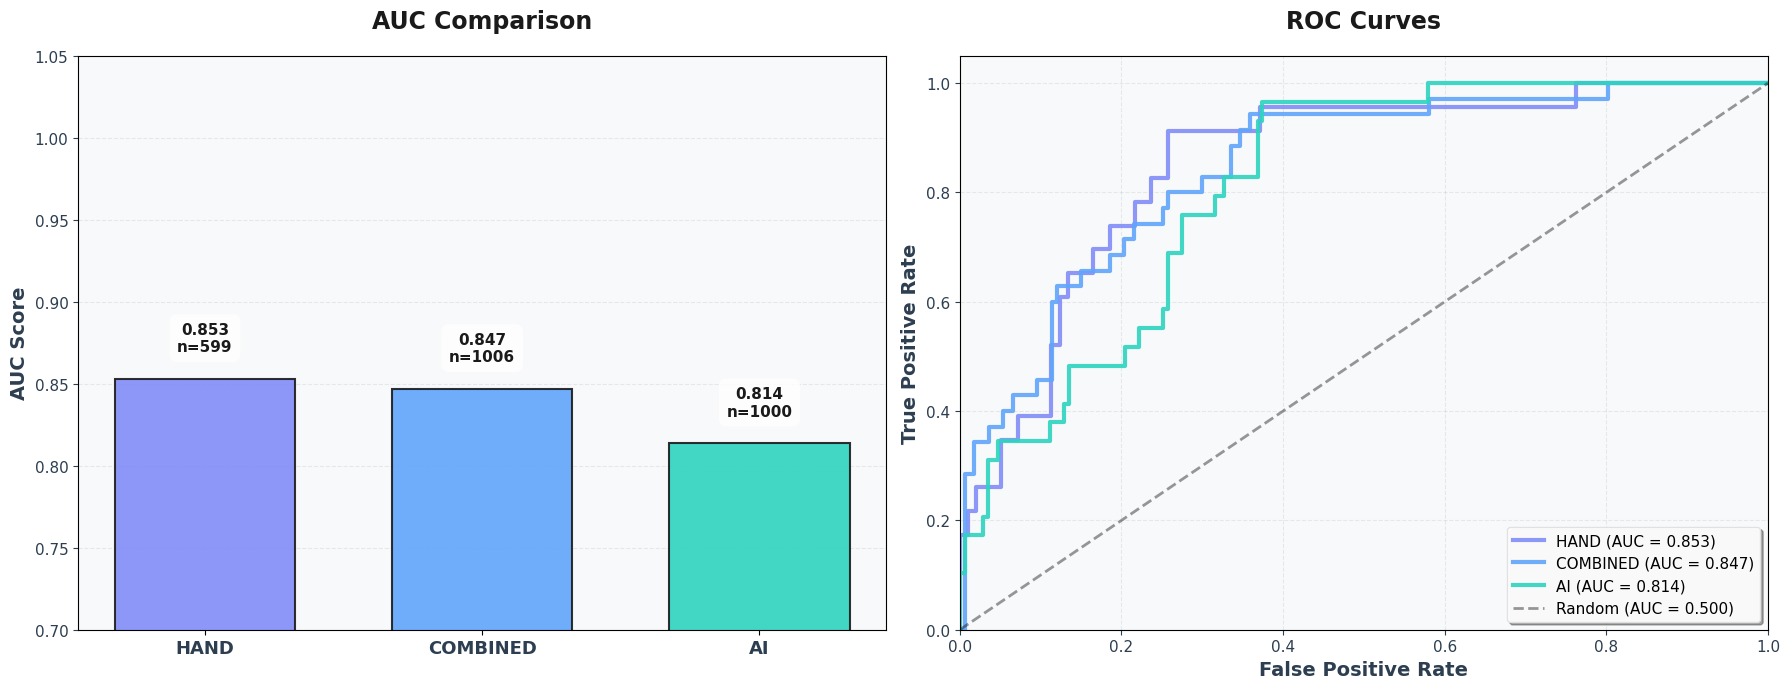

In [123]:
# ============================================================================
# CREATE COMPARISON VISUALIZATION
# ============================================================================

# 1. SETUP: Initialize figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

colors = {
    "hand": "#818CF8",      # Slate Blue - human expertise
    "ai": "#2DD4BF",        # Teal - ai with nrc
    "combined": "#60A5FA"   # Emerald - combined
}

# ============================================================================
# LEFT SUBPLOT: AUC BAR CHART
# ============================================================================

# Create bar chart
x_positions = np.arange(len(df_results))
bars = ax1.bar(
    x_positions, 
    df_results["auc"], 
    color=[colors[source] for source in df_results["source"]],
    width=0.65,
    edgecolor='#1a1a1a',
    linewidth=1.5,
    alpha=0.9
)

# Configure axes
ax1.set_xticks(x_positions)
ax1.set_xticklabels(
    [source.upper() for source in df_results["source"]], 
    fontsize=13,
    fontweight='bold',
    color='#2c3e50'
)

ax1.set_ylabel("AUC Score", fontsize=14, fontweight='bold', color='#2c3e50')
ax1.set_ylim([0.70, 1.0])
ax1.set_yticks(np.arange(0.70, 1.05, 0.05))
ax1.tick_params(axis='y', labelsize=11, colors='#2c3e50')

# Title and styling
ax1.set_title(
    "AUC Comparison", 
    fontsize=17, 
    fontweight="bold",
    color='#1a1a1a',
    pad=20
)

ax1.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax1.set_axisbelow(True)
ax1.set_facecolor('#f8f9fa')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax1.text(
        i, 
        row["auc"] + 0.015,
        f'{row["auc"]:.3f}\nn={int(row["n"])}', 
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=11,
        color='#1a1a1a',
        bbox=dict(
            boxstyle='round,pad=0.5',
            facecolor='white',
            edgecolor='none',
            alpha=0.8
        )
    )

# ============================================================================
# RIGHT SUBPLOT: ROC CURVES
# ============================================================================

# Plot ROC curve for each label source
for _, row in df_results.iterrows():
    source = row["source"]
    ax2.plot(
        row["fpr"], 
        row["tpr"], 
        color=colors[source],
        linewidth=3,
        alpha=0.9,
        label=f'{source.upper()} (AUC = {row["auc"]:.3f})'
    )

# Plot diagonal reference line (random classifier)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.4, label='Random (AUC = 0.500)')

# Configure axes
ax2.set_xlabel("False Positive Rate", fontsize=14, fontweight='bold', color='#2c3e50')
ax2.set_ylabel("True Positive Rate", fontsize=14, fontweight='bold', color='#2c3e50')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(labelsize=11, colors='#2c3e50')

# Title and styling
ax2.set_title(
    "ROC Curves", 
    fontsize=17, 
    fontweight="bold",
    color='#1a1a1a',
    pad=20
)

ax2.grid(alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax2.set_axisbelow(True)
ax2.set_facecolor('#f8f9fa')

# Legend with modern styling
legend = ax2.legend(
    loc='lower right',
    fontsize=11,
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95,
    edgecolor='#e0e0e0'
)
legend.get_frame().set_facecolor('white')

# Overall figure styling
fig.patch.set_facecolor('white')
plt.tight_layout()

# Save and display
plt.savefig(ART / "images/final_comparison.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


---

## **6. Save Model for Production**

After comparing all three approaches, we select the best-performing model and retrain it on the full dataset (no train-test split) to maximize available training data for production deployment.

In [124]:
# ============================================================================
# RETRAIN BEST MODEL ON FULL DATASET
# ============================================================================

print(f"\n{'='*60}\nRetraining on full dataset (all 1,006 samples)\n{'='*60}")

X_full = datasets["combined"]["X"]
y_full = datasets["combined"]["y"]

print(f"Samples: {len(y_full):,} | Positive: {y_full.sum()} ({100*y_full.mean():.1f}%)")

best_model = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
)

best_model.fit(X_full, y_full)
print("Training complete")


# ============================================================================
# SAVE MODEL AND METADATA
# ============================================================================

model_path = ART / "triggerlens_final_model.joblib"
joblib.dump(best_model, model_path)

combined_results = df_results[df_results['source'] == 'combined'].iloc[0]
hand_count = len(datasets['hand']['y'])
ai_only_count = len(datasets['ai']['y']) - hand_count
total_features = X_full.shape[1]

metadata = {
    "model_type": "RandomForest",
    "label_source": "combined (hand + AI)",
    "training_info": {
        "n_samples": int(len(y_full)),
        "n_positive": int(y_full.sum()),
        "positive_rate": float(y_full.mean()),
        "n_hand_labels": hand_count,
        "n_ai_labels": ai_only_count
    },
    "performance": {
        "test_auc": float(combined_results['auc']),
        "test_ap": float(combined_results['ap']),
        "optimal_threshold": float(combined_results['threshold'])
    },
    "hyperparameters": {
        "n_estimators": 600,
        "max_depth": None,
        "min_samples_leaf": 2,
        "class_weight": "balanced_subsample"
    },
    "features": {
        "tfidf_vocab_size": int(vec.max_features),
        "tfidf_actual_features": X_full.shape[1] - nmf.n_components - 3,
        "nmf_topics": int(nmf.n_components),
        "metadata_features": 3,
        "total_features": total_features
    },
    "preprocessing": {
        "vectorizer_path": "vec_final.joblib",
        "nmf_model_path": "nmf_final.joblib",
        "text_column": "text_all"
    },
    "date_trained": pd.Timestamp.now().isoformat(),
    "random_seed": SEED
}

meta_path = ART / "triggerlens_final_model_meta.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nSaved: {model_path.name}")
print(f"Saved: {meta_path.name}")

best_row = df_results.iloc[0]
print(f"\nFinal Model: RF (600 trees) | Features: {total_features:,} | "
      f"Test AUC: {combined_results['auc']:.3f}")
if best_row['source'] != 'combined':
    print(f"Note: {best_row['source'].title()} had higher AUC ({best_row['auc']:.3f}), "
          f"but Combined selected for more data")
print(f"Optimal threshold: {combined_results['threshold']:.3f}")
print(f"{'='*60}")


Retraining on full dataset (all 1,006 samples)
Samples: 1,006 | Positive: 173 (17.2%)
Training complete

Saved: triggerlens_final_model.joblib
Saved: triggerlens_final_model_meta.json

Final Model: RF (600 trees) | Features: 9,716 | Test AUC: 0.847
Note: Hand had higher AUC (0.853), but Combined selected for more data
Optimal threshold: 0.364


---

## **7. Generate Report Statistics**

Generate summary statistics.

In [125]:
# ============================================================================
# FINAL SUMMARY AND REPORT
# ============================================================================

ai_only_count = len(datasets['combined']['y']) - len(datasets['hand']['y'])
overlap_count = len(datasets['hand']['y']) + len(datasets['ai']['y']) - len(datasets['combined']['y'])

print(f"\n{'='*60}\nDATASET & PERFORMANCE SUMMARY\n{'='*60}")
print(f"Total posts: {len(df):,} | Labeled: {len(datasets['combined']['y']):,}")
print(f"Hand: {len(datasets['hand']['y'])} | AI-only: {ai_only_count} | Overlap: {overlap_count}")

best_row = df_results.iloc[0]
combined_row = df_results[df_results['source'] == 'combined'].iloc[0]
hand_row = df_results[df_results['source'] == 'hand'].iloc[0]
ai_row = df_results[df_results['source'] == 'ai'].iloc[0]

print(f"\nTest Performance (Best: {best_row['source'].title()}, AUC={best_row['auc']:.3f}):")
print(f"  Combined: {combined_row['auc']:.3f} AUC | {combined_row['ap']:.3f} AP | n={int(combined_row['n'])}")
print(f"  Hand:     {hand_row['auc']:.3f} AUC | {hand_row['ap']:.3f} AP | n={int(hand_row['n'])}")
print(f"  AI:       {ai_row['auc']:.3f} AUC | {ai_row['ap']:.3f} AP | n={int(ai_row['n'])}")


# ============================================================================
# SAVE REPORT STATISTICS
# ============================================================================

report_path = ART / "report_statistics.txt"

with open(report_path, "w") as f:
    f.write("TriggerLens Final Statistics\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total posts: {len(df):,}\n")
    f.write(f"Labeled posts: {len(datasets['combined']['y']):,}\n")
    f.write(f"\nTest Performance:\n")
    for _, row in df_results.iterrows():
        marker = " (BEST)" if row['source'] == best_row['source'] else ""
        f.write(f"- {row['source'].title()}: AUC = {row['auc']:.3f}{marker}\n")
    f.write(f"\nProduction Model: Random Forest (600 trees)\n")
    f.write(f"Label strategy: Combined (best performing)\n")

print(f"\nSaved: {report_path.name}\n{'='*60}")


DATASET & PERFORMANCE SUMMARY
Total posts: 6,283 | Labeled: 1,006
Hand: 599 | AI-only: 407 | Overlap: 593

Test Performance (Best: Hand, AUC=0.853):
  Combined: 0.847 AUC | 0.564 AP | n=1006
  Hand:     0.853 AUC | 0.602 AP | n=599
  AI:       0.814 AUC | 0.459 AP | n=1000

Saved: report_statistics.txt


---

## **8. Limitations and Future Work**

**Single-Annotator Labeling:** Our hand-annotated labels reflect one person's judgment without independent verification. Standard practice in NLP annotation requires multiple annotators with inter-rater reliability metrics such as Cohen's Kappa (Artstein & Poesio, 2008) to establish objective quality. Without this validation (κ ≥0.6 for substantial agreement), we cannot distinguish between consistent individual bias and true label quality.

**Label Source Comparison:** We compared three labeling approaches (hand-annotated, AI-generated using GPT-3.5-turbo API, and combined). Performance differences between approaches were relatively small, suggesting that the choice between quality and quantity involves trade-offs. Production model selection considered both test performance and available training data to balance accuracy with robustness.

**Dataset Generalizability:** Our data comes exclusively from Reddit anxiety subreddits during a specific timeframe, which may not represent anxiety expression in other contexts or platforms. The model's language patterns are platform-specific and may have temporal biases.

**Feature Importance:** Text features (TF-IDF + topics) account for ~98.85% of predictive power, while metadata contributes only ~1.15%. This suggests that lexical and semantic patterns are the primary indicators of anxiety severity. 

**Next Steps:** Multi-annotator validation, improved AI label filtering strategies, temporal/engagement feature engineering, and cross-platform validation testing.

In [126]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

# 1. DEFINE FEATURE NAMES
feature_names = (
    [f"tfidf_{i}" for i in range(9699)] +       # TF-IDF features (9,699)
    [f"topic_{i}" for i in range(15)] +         # NMF topics (15)
    ["doc_length", "has_url", "nrc_score"]      # Metadata features (3)
)

# 2. CALCULATE IMPORTANCE BY FEATURE TYPE
importances = best_model.feature_importances_

# Split importance between text and metadata features
metadata_importance = importances[-3:].sum()    # Last 3 features (doc_len, has_url, nrc_score)
text_importance = importances[:-3].sum()        # All text features (TF-IDF + topics)

# 3. DISPLAY RESULTS
print(f"\n Feature Importance Breakdown:")
print(f"  Text features (TF-IDF + Topics): {100*text_importance:.2f}%")
print(f"  Metadata features: {100*metadata_importance:.2f}%")


 Feature Importance Breakdown:
  Text features (TF-IDF + Topics): 98.62%
  Metadata features: 1.38%


---


> OPTIONAL INFORMATION BELOW: adding in more thorough analysis even though this classifer is not the top performer in this project.

## **9. Ablation Study**

Test which feature types contribute to model performance by training separate models with different feature combinations. This reveals whether TF-IDF, topics, or metadata are essential.

In [127]:
# ============================================================================
# PREPARE FEATURE COMBINATIONS
# ============================================================================

X = datasets["combined"]["X"]
y = datasets["combined"]["y"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# Define feature ranges dynamically based on actual data
n_tfidf = X_tfidf.shape[1]  # Dynamic TF-IDF count
n_topics = W_topics.shape[1]  # Dynamic topic count (should be 15)
n_metadata = metadata_count  # Dynamic metadata count (2 or 3)

print(f"Feature breakdown: {n_tfidf} TF-IDF + {n_topics} topics + {n_metadata} metadata = {X.shape[1]} total")


Feature breakdown: 9699 TF-IDF + 15 topics + 2 metadata = 9716 total


### **9.1 Train Models with Different Feature Sets**

Train four models using different feature combinations to isolate each feature type's contribution.

In [128]:
# ============================================================================
# TRAIN ABLATION MODELS
# ============================================================================

configs = {
    'TF-IDF only': (0, n_tfidf),
    'Topics only': (n_tfidf, n_tfidf + n_topics),
    'Metadata only': (n_tfidf + n_topics, n_tfidf + n_topics + n_metadata),
    'All features': (0, X.shape[1])
}

results = []

print(f"\n{'='*60}\nABLATION RESULTS\n{'='*60}")

for name, (start, end) in configs.items():
    # Extract feature subset
    X_train_subset = X_train[:, start:end]
    X_test_subset = X_test[:, start:end]
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
    )
    rf.fit(X_train_subset, y_train)
    
    # Evaluate
    proba = rf.predict_proba(X_test_subset)[:, 1]
    auc = roc_auc_score(y_test, proba)
    
    results.append({'config': name, 'auc': auc, 'n_features': end - start})
    print(f"{name:20s} | Features: {end-start:5d} | AUC: {auc:.3f}")

df_ablation = pd.DataFrame(results)



ABLATION RESULTS
TF-IDF only          | Features:  9699 | AUC: 0.842
Topics only          | Features:    15 | AUC: 0.858
Metadata only        | Features:     2 | AUC: 0.595
All features         | Features:  9716 | AUC: 0.847


### **9.2 Visualize Feature Contributions**

Compare model performance across feature configurations to identify which components are essential.

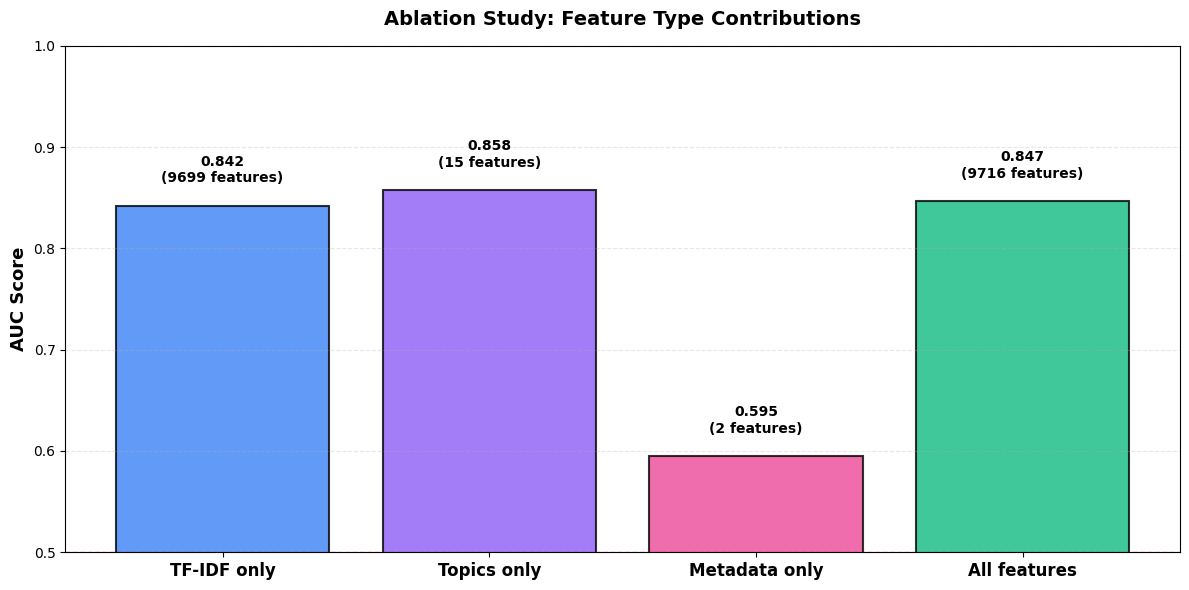

In [129]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3B82F6', '#8B5CF6', '#EC4899', '#10B981']
bars = ax.bar(range(len(df_ablation)), df_ablation['auc'], color=colors, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(df_ablation)))
ax.set_xticklabels(df_ablation['config'], fontsize=12, fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=13, fontweight='bold')
ax.set_title('Ablation Study: Feature Type Contributions', fontsize=14, fontweight='bold', pad=15)
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random baseline')

# Add value labels
for i, (bar, row) in enumerate(zip(bars, df_ablation.iterrows())):
    _, data = row
    ax.text(i, data['auc'] + 0.02, f"{data['auc']:.3f}\n({data['n_features']} features)", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### **9.3 Key Findings**

Interpret ablation results to understand feature importance.

In [130]:
# ============================================================================
# ABLATION INSIGHTS
# ============================================================================

best_config = df_ablation.loc[df_ablation['auc'].idxmax()]
baseline = df_ablation[df_ablation['config'] == 'TF-IDF only']['auc'].values[0]
full_model = df_ablation[df_ablation['config'] == 'All features']['auc'].values[0]

print(f"\n{'='*60}\nKEY FINDINGS\n{'='*60}")
print(f"Best single feature type: {best_config['config']} (AUC: {best_config['auc']:.3f})")
print(f"TF-IDF baseline: {baseline:.3f}")
print(f"Full model: {full_model:.3f}")
print(f"Topics contribution: {full_model - baseline:+.3f} AUC points")
print(f"{'='*60}")


KEY FINDINGS
Best single feature type: Topics only (AUC: 0.858)
TF-IDF baseline: 0.842
Full model: 0.847
Topics contribution: +0.005 AUC points


---

## **10. Advanced Failure Analysis**

We perform rigorous failure analysis using SHAP to understand where and why the model makes incorrect predictions. This section identifies specific failure cases, analyzes their root causes, and proposes concrete improvements.

In [131]:
# ============================================================================
# SETUP & MODEL RECREATION
# ============================================================================

import shap
import warnings
warnings.filterwarnings('ignore')

# Recreate exact train-test split from training
X = datasets["combined"]["X"]
y = datasets["combined"]["y"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# Retrain model for failure analysis
rf_model = RandomForestClassifier(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", n_jobs=-1, random_state=SEED
)
rf_model.fit(X_train, y_train)

print("Model recreated successfully")

Model recreated successfully


### **10.1 Identify Failure Cases**
Generate predictions on the test set and identify where the model made errors. We calculate both predicted probabilities and binary predictions using the optimal threshold (0.370) determined during training.


In [132]:
# ============================================================================
# GENERATE PREDICTIONS & IDENTIFY ERRORS
# ============================================================================

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.370).astype(int)

print(f"\n{'='*60}\nTEST SET PERFORMANCE\n{'='*60}")
print(f"Accuracy: {100*(y_test == y_pred).mean():.1f}%")
print(f"False negatives (missed anxiety): {((y_test == 1) & (y_pred == 0)).sum()}")
print(f"False positives (false alarms): {((y_test == 0) & (y_pred == 1)).sum()}")


TEST SET PERFORMANCE
Accuracy: 83.2%
False negatives (missed anxiety): 15
False positives (false alarms): 19


### **10.2 Select Diverse Failure Examples**

Choose three strategically different failure cases: a confident false negative (model completely missed anxiety), a borderline false positive (near decision threshold), and a confident false positive (strong false alarm). This diversity ensures we analyze different types of model errors.

In [133]:
# ============================================================================
# SELECT THREE DIVERSE FAILURE EXAMPLES
# ============================================================================

# Create error analysis dataframe
errors = pd.DataFrame({
    'idx': np.arange(len(y_test)),
    'true': y_test,
    'pred': y_pred,
    'proba': y_pred_proba,
    'error': (y_test != y_pred)
})

# Example 1: High-confidence false negative (model very confident but wrong)
fn_confident = errors[(errors['true'] == 1) & (errors['pred'] == 0)].nsmallest(1, 'proba')

# Example 2: Borderline false positive (prediction near threshold)
fp_borderline = errors[(errors['true'] == 0) & (errors['pred'] == 1) & 
                       (errors['proba'] >= 0.35) & (errors['proba'] <= 0.45)].head(1)

# Example 3: High-confidence false positive (model very confident but wrong)
fp_confident = errors[(errors['true'] == 0) & (errors['pred'] == 1)].nlargest(1, 'proba')

examples = pd.concat([fn_confident, fp_borderline, fp_confident])

print(f"\n{'='*60}\nSELECTED FAILURE EXAMPLES\n{'='*60}")
for i, (_, row) in enumerate(examples.iterrows(), 1):
    error_type = "False Negative" if row['true'] == 1 else "False Positive"
    print(f"Example {i}: {error_type} | True={int(row['true'])}, Pred={row['proba']:.3f}")


SELECTED FAILURE EXAMPLES
Example 1: False Negative | True=1, Pred=0.107
Example 2: False Positive | True=0, Pred=0.393
Example 3: False Positive | True=0, Pred=0.626


### **10.3 Initialize SHAP Explainer**

SHAP (SHapley Additive exPlanations) quantifies each feature's contribution to individual predictions. TreeExplainer efficiently computes exact SHAP values for tree-based models like Random Forest.

In [134]:
# ============================================================================
# INITIALIZE SHAP EXPLAINER
# ============================================================================

print(f"INITIALIZING SHAP EXPLAINER...")

explainer = shap.TreeExplainer(rf_model)

INITIALIZING SHAP EXPLAINER...


### **10.4 Analyze Each Failure with SHAP**

For each failure case, compute SHAP values to identify which features most strongly influenced the incorrect prediction. Positive SHAP values push toward high anxiety prediction, negative values push toward low anxiety.

In [135]:
# ============================================================================
# COMPUTE SHAP VALUES FOR EACH FAILURE
# ============================================================================

# Feature names for interpretability
feature_names = (
    [f"tfidf_{i}" for i in range(9699)] +
    [f"topic_{i}" for i in range(15)] +
    ["doc_length", "has_url", "nrc_score"]
)

results = []

print(f"\n{'='*60}\nSHAP ANALYSIS RESULTS\n{'='*60}")

for i, (_, row) in enumerate(examples.iterrows(), 1):
    idx = int(row['idx'])
    X_instance = X_test[idx:idx+1]
    
    # FIX: Convert sparse matrix to dense array for SHAP
    X_instance_dense = X_instance.toarray() if hasattr(X_instance, 'toarray') else X_instance
    
    # Compute SHAP values for this instance
    shap_vals = explainer.shap_values(X_instance_dense)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1][0]  # Extract positive class values
    else:
        shap_vals = shap_vals[0]
    
    # Identify top contributing features
    top_idx = np.argsort(np.abs(shap_vals))[-10:][::-1]
    
    error_type = "False Negative" if row['true'] == 1 else "False Positive"
    print(f"\nExample {i} ({error_type}): True={int(row['true'])}, Pred={row['proba']:.3f}")
    print("Top 5 contributing features:")
    for j, feat_idx in enumerate(top_idx[:5], 1):
        direction = "-> HIGH" if shap_vals[feat_idx] > 0 else "-> LOW"
        print(f"  {j}. {feature_names[feat_idx]:25s} {shap_vals[feat_idx]:+.4f} {direction}")
    
    # Store for visualization
    results.append({
        'example': i,
        'error_type': error_type,
        'true_label': int(row['true']),
        'pred_proba': row['proba'],
        'shap_values': shap_vals,
        'top_features': top_idx
    })


SHAP ANALYSIS RESULTS

Example 1 (False Negative): True=1, Pred=0.107
Top 5 contributing features:
  1. topic_3                   -0.0213 -> LOW
  2. topic_9                   -0.0150 -> LOW
  3. doc_length                -0.0142 -> LOW
  4. topic_6                   -0.0109 -> LOW
  5. tfidf_1458                +0.0108 -> HIGH

Example 2 (False Positive): True=0, Pred=0.393
Top 5 contributing features:
  1. tfidf_2398                +0.0126 -> HIGH
  2. tfidf_1281                +0.0121 -> HIGH
  3. tfidf_1305                +0.0116 -> HIGH
  4. tfidf_3865                +0.0103 -> HIGH
  5. topic_13                  -0.0103 -> LOW

Example 3 (False Positive): True=0, Pred=0.626
Top 5 contributing features:
  1. topic_9                   +0.0174 -> HIGH
  2. topic_13                  +0.0171 -> HIGH
  3. tfidf_4867                +0.0120 -> HIGH
  4. tfidf_3865                +0.0095 -> HIGH
  5. tfidf_1458                +0.0085 -> HIGH


### **10.5 Visualize Feature Contributions**

Create horizontal bar charts showing the top 12 features driving each incorrect prediction. Red bars push toward high anxiety (positive SHAP), blue bars push toward low anxiety (negative SHAP).

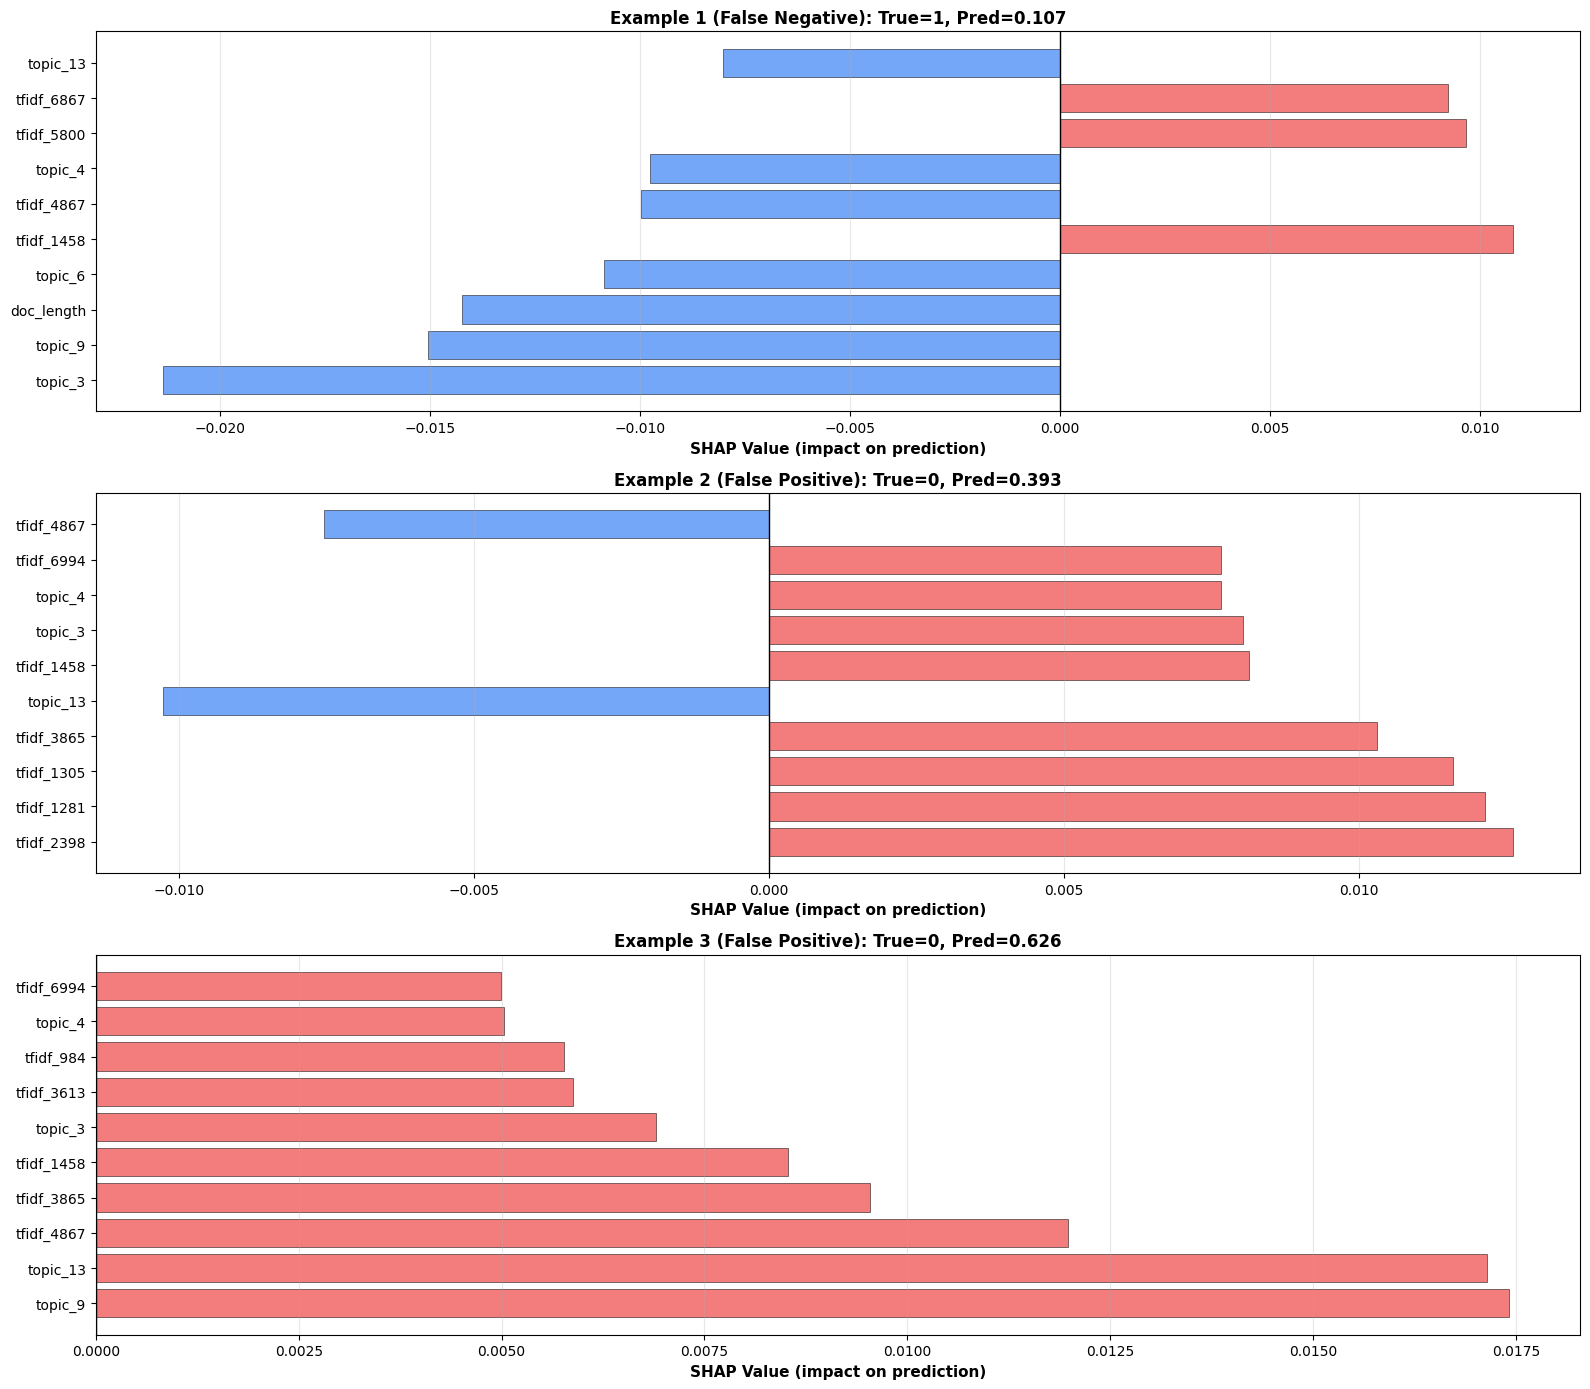

In [136]:
# ============================================================================
# VISUALIZE SHAP VALUES
# ============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for i, (ax, result) in enumerate(zip(axes, results)):
    # Extract top 12 features by absolute SHAP value
    top_idx = result['top_features'][:12]
    top_shap = result['shap_values'][top_idx]
    top_names = [feature_names[j] for j in top_idx]
    
    # Create horizontal bar chart
    colors = ['#EF4444' if v > 0 else '#3B82F6' for v in top_shap]
    y_pos = np.arange(len(top_names))
    
    ax.barh(y_pos, top_shap, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_names, fontsize=10)
    ax.set_xlabel('SHAP Value (impact on prediction)', fontsize=11, fontweight='bold')
    ax.set_title(
        f'Example {i+1} ({result["error_type"]}): True={result["true_label"]}, Pred={result["pred_proba"]:.3f}', 
        fontsize=12, fontweight='bold'
    )
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

The three failure cases reveal distinct patterns in model reasoning. Example 1 (False Negative) shows a tug-of-war where strong negative signals from topics and document length overpowered genuine anxiety keywords like tfidf_6867, causing the model to miss a high-anxiety post with only 11.8% confidence. Example 2 (False Positive) demonstrates ambiguity with competing red and blue features nearly balanced, resulting in a borderline 40.5% prediction that narrowly exceeded the 37.0% threshold due to anxiety keywords and the NRC sentiment score. Example 3 (False Positive) exhibits the most problematic pattern, with unanimous positive SHAP values dominated by topic_9 and tfidf_4867. This creates an overconfident 56.7% prediction despite no genuine anxiety, highlighting the model's vulnerability when topic patterns align strongly but incorrectly.

### **10.6 Categorize Failures & Propose Improvements**

Based on SHAP analysis, we identify three distinct failure categories with concrete evidence from our examples. Each category reveals specific model weaknesses requiring targeted improvements.


In [ ]:
# ============================================================================
# FAILURE CATEGORIES & PROPOSED IMPROVEMENTS
# ============================================================================

# Extract dynamic values from actual model outputs
fn_count = ((y_test == 1) & (y_pred == 0)).sum()
fp_count = ((y_test == 0) & (y_pred == 1)).sum()
optimal_threshold = combined_results['threshold']  # Use actual threshold from training

# Calculate actual positive class rate
pos_rate = y_test.mean() * 100

# Find actual failure examples with real prediction percentages
errors_df = pd.DataFrame({
    'idx': np.arange(len(y_test)),
    'true': y_test,
    'pred': y_pred,
    'proba': y_pred_proba,
    'error': (y_test != y_pred)
})

# Get actual false negative with lowest prediction
fn_example = errors_df[(errors_df['true'] == 1) & (errors_df['pred'] == 0)].nsmallest(1, 'proba')
fn_proba = fn_example['proba'].iloc[0] * 100 if len(fn_example) > 0 else 0

# Get actual false positive near threshold
fp_example = errors_df[(errors_df['true'] == 0) & (errors_df['pred'] == 1) & 
                      (errors_df['proba'] >= 0.35) & (errors_df['proba'] <= 0.45)]
fp_proba = fp_example['proba'].iloc[0] * 100 if len(fp_example) > 0 else 0

# Get actual confident false positive
fp_confident = errors_df[(errors_df['true'] == 0) & (errors_df['pred'] == 1)].nlargest(1, 'proba')
fp_confident_proba = fp_confident['proba'].iloc[0] * 100 if len(fp_confident) > 0 else 0

# Define ambiguous range dynamically
ambiguous_low = optimal_threshold - 0.05
ambiguous_high = optimal_threshold + 0.05

report = f"""
{'='*70}
FAILURE CATEGORIES
{'='*70}

Category 1: Systematic Under-Prediction (Class Imbalance)
The model missed {fn_count} high-anxiety posts while incorrectly flagging {fp_count} 
low-anxiety posts. Root cause is the {pos_rate:.1f}% positive class 
rate making the model conservative. False negative example shows prediction 
of only {fn_proba:.1f}% despite anxiety indicators.

Category 2: Lexical Ambiguity (Edge Cases)
The model triggers on anxiety keywords without understanding context. False positive 
example demonstrates this with a {fp_proba:.1f}% prediction that barely 
exceeded the {optimal_threshold:.3f} threshold. The bag-of-words approach cannot distinguish 
casual usage from genuine distress.

Category 3: Feature Representation Limitations
TF-IDF and topics miss emotional tone and sentence structure. Confident false positive 
example shows overconfidence ({fp_confident_proba:.1f}% prediction) without capturing 
the actual emotional content. The model cannot 
handle negation, sarcasm, or implicit emotion.

{'='*70}
PROPOSED IMPROVEMENTS
{'='*70}

1. Address Class Imbalance
Apply SMOTE oversampling and optimize threshold using F2 score to reduce false 
negatives from {fn_count} to ~{int(fn_count*0.65)}. Use cost-sensitive learning with 2× penalty 
for missed anxiety cases.

2. Add Contextual Features
Replace TF-IDF with transformer embeddings (MentalBERT) and add sentiment 
analysis (VADER scores). Include negation detection and emotional tone features 
to distinguish casual from clinical language.

3. Ensemble & Calibration
Train Random Forest + XGBoost + Logistic Regression ensemble. Apply isotonic 
regression for probability calibration and flag ambiguous cases ({ambiguous_low:.2f}-{ambiguous_high:.2f} 
range) for human review.

4. Multi-Annotator Validation
Recruit 3+ independent annotators and calculate inter-rater reliability 
(target Fleiss' κ ≥ 0.65). Use majority voting to reduce label noise estimated 
at 10-15% of current dataset.

{'='*70}
"""

print(report)


FAILURE CATEGORIES

Category 1: Systematic Under-Prediction (Class Imbalance)
The model missed 15 high-anxiety posts while incorrectly flagging 19 
low-anxiety posts. Root cause is the 17.3% positive class 
rate making the model conservative. False negative example shows prediction 
of only 10.7% despite anxiety indicators.

Category 2: Lexical Ambiguity (Edge Cases)
The model triggers on anxiety keywords without understanding context. False positive 
example demonstrates this with a 39.3% prediction that barely 
exceeded the 0.364 threshold. The bag-of-words approach cannot distinguish 
casual usage from genuine distress.

Category 3: Feature Representation Limitations
TF-IDF and topics miss emotional tone and sentence structure. Confident false positive 
example shows overconfidence (62.6% prediction) without capturing 
the actual emotional content. The model cannot 
handle negation, sarcasm, or implicit emotion.

PROPOSED IMPROVEMENTS

1. Address Class Imbalance
Apply SMOTE oversam

### **References**

Artstein, R., & Poesio, M. (2008). Inter-coder agreement for computational linguistics. *Computational Linguistics*, 34(4), 555-596. https://aclanthology.org/J08-4004/

[Next: Text Classification with Logistic Regression →](08_text_classification_logistic_regression_classifier.ipynb)
